In [3]:

import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Trace_ELBO
import torch

import seaborn as sns
import matplotlib.pyplot as plt




# Model

A poisson model with a somewhat complex prior on expected counts.


In [4]:

def model():
    A = pyro.sample('A', dist.Normal(0, 1))
    B = pyro.sample('B', dist.LogNormal(0, 1))
    C = pyro.sample('C', dist.LogNormal(A, B))
    X = pyro.sample('X', dist.Poisson(C))


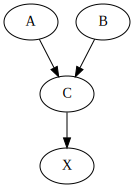

In [6]:

pyro.render_model(model, model_args=())



# Samples

Generate samples using poutine.trace


In [7]:

pyro.set_rng_seed(2022)
pyro.clear_param_store()

model_trace = pyro.poutine.trace(model)

samples = model_trace.get_trace()

for a in ('A', 'B', 'C', 'X'):
    print(a, samples.nodes[a]['value'].detach().numpy())


A 0.1915114
B 1.391842
C 1.6694775
X 2.0



# Model 2

Modify the model to generate multiple independent observations given the same prior over expected counts using pyro.plate.


In [15]:

def model(n_data):
    A = pyro.sample('A', dist.Normal(0, 1))
    B = pyro.sample('B', dist.LogNormal(0, 1))
    C = pyro.sample('C', dist.LogNormal(A, B))
    with pyro.plate('N', n_data):
        X = pyro.sample('X', dist.Poisson(C))


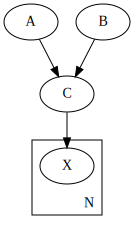

In [16]:

pyro.render_model(model, model_kwargs={'n_data': 1})


A 0.1915114
B 1.391842
C 1.6694775


<AxesSubplot:ylabel='count'>

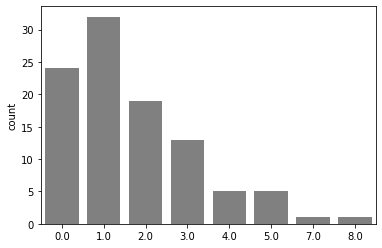

In [17]:

pyro.set_rng_seed(2022)
pyro.clear_param_store()

model_trace = pyro.poutine.trace(model)

samples = model_trace.get_trace(n_data=100)

for a in ('A', 'B', 'C'):
    print(a, samples.nodes[a]['value'].detach().numpy())

sns.countplot(x=samples.nodes['X']['value'].numpy(), color='0.5')



# Conditioning using poutine

We can use poutine to modify our model, conditioning on any of the random variables, using poutine.condition.


A [0.1]
B 1.2110786
C [1.6494082]


<AxesSubplot:ylabel='count'>

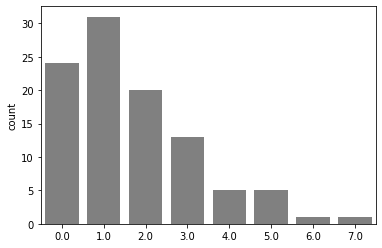

In [18]:

pyro.set_rng_seed(2022)
pyro.clear_param_store()

conditioned_model = pyro.poutine.condition(
    model,
    data={
        'A': torch.tensor([0.1]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(n_data=100)

for a in ('A', 'B', 'C'):
    print(a, samples.nodes[a]['value'].detach().numpy())

sns.countplot(x=samples.nodes['X']['value'].detach().numpy(), color='0.5')



Lets use data sampled from the model to explore inference techniques


In [19]:

data = samples.nodes['X']['value'].detach()



# Model 3

Modify the model to be useful for sampling and inference by taking either number of samples to generate or the observed data.


In [20]:

def model(data=None, n_data=None):
    assert (data is None) != (n_data is None)
    if n_data is None:
        n_data = data.shape[0]
    A = pyro.sample('A', dist.Normal(0, 1))
    B = pyro.sample('B', dist.LogNormal(0, 1))
    C = pyro.sample('C', dist.LogNormal(A, B))
    with pyro.plate('N', n_data):
        X = pyro.sample('X', dist.Poisson(C), obs=data)



# Inference

Use the Adam optimizer, Trace_ELBO based SVI and an AutoNormal guide to infer A, B, C from our data


In [21]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=2)
guide = AutoNormal(pyro.poutine.block(model, expose=['A', 'B', 'C']))
svi = SVI(model, guide, optim, loss=elbo)



...............................................................................
...............................................................................
...............................................................................
...........................................................

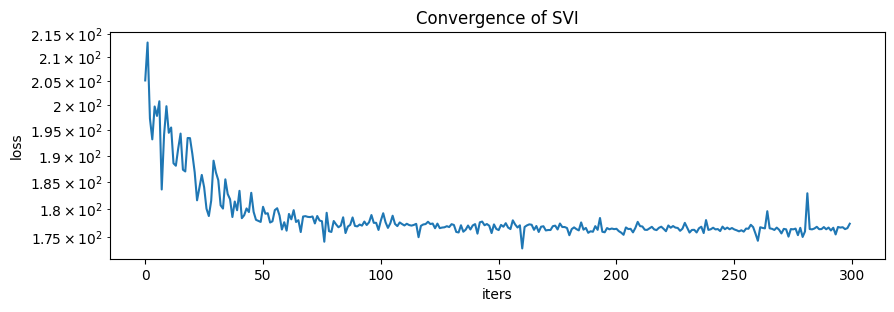

In [22]:

pyro.clear_param_store()

losses = []
for i in range(300):
    loss = svi.step(data=data)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


In [23]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k].detach())


AutoNormal.locs.A tensor(0.3994)
AutoNormal.scales.A tensor(0.4253)
AutoNormal.locs.B tensor(-0.3320)
AutoNormal.scales.B tensor(0.5488)
AutoNormal.locs.C tensor(0.5266)
AutoNormal.scales.C tensor(0.0804)



# Model evaluation

We can evaluate our model by generating samples from the posterior and comparing with the known hidden variables and observed data.  Use pyro.infer.Predictive to generate 1000 samples of 100 data points each, summarize, and compare.


In [27]:

import pandas as pd
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)(n_data=100)

svi_samples = pd.DataFrame({k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive.items()
               if k != 'X'})
svi_samples.describe().T


,count,mean,std,min,25%,50%,75%,max
A,1000.0,0.384935,0.427080,-0.896832,0.110024,0.392561,0.654626,1.854189
B,1000.0,0.839663,0.519185,0.134799,0.475898,0.712569,1.038665,3.686559
C,1000.0,1.690715,0.139130,1.306041,1.596905,1.676795,1.778836,2.166081


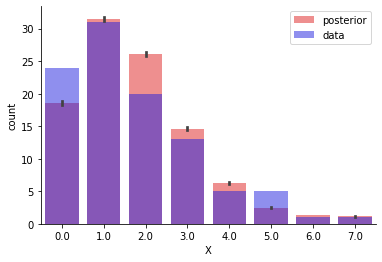

In [28]:

svi_samples = pd.DataFrame([pd.Series(a).value_counts() for a in predictive['X']])
svi_samples = svi_samples.stack().reset_index()
svi_samples.columns = ['sample', 'X', 'count']

sns.barplot(x='X', y='count', data=svi_samples, color='r', alpha=0.5, label='posterior')
sns.countplot(x=data.detach().numpy(), color='b', alpha=0.5, label='data')
plt.legend()
sns.despine()



# Additional exercises

1. Try increasing the amount of data to see if our estimates improve
2. Assess the effect of using a different guide
3. Write your own guide using a mean field approach.



# Answer Key from here:

TODO
